
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>




#### Midé Mabadeje$^{1}$ [GitHub](https://github.com/Mide478) | [GoogleScholar](https://scholar.google.com/citations?user=9nksjzQAAAAJ&hl=en&oi=ao)  | [LinkedIn](https://www.linkedin.com/in/ademidemabadeje) & Michael Pyrcz$^{1,2}$ (Professor) [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1), University of Texas at Austin

 1. Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
 

 2. Department of Earth & Planetary Sciences, Jackson School of Geosciences


# Spatial Data Analytics to Support Declustering Approaches


## Executive Summary
All sparsely sampled, spatial datasets are biased. Cell-based declustering (CBD) is the most applied approach for debiasing such datasets. Current practice for choice of cell size in CBD is irrational and subjective because it is overly conservative. We propose a novel method, Spatial Statistics-based Assignment of Declustering Cell Size (SSADC), which objectively selects the cell size using spatial point statistics; Nearest Neighbors and Ripley’s K to determine the scales of data clustering between data points.

SSADC provides an alternative input for optimal cell size selection using spatial statistics in CBD with the aim to automate and improve objectivity for the mitigation of sampling bias. Cell size determined via SSADC was found to be a better estimate of the true mean regardless of the degree of bias in the data. Therefore, the proposed method is recommended for automated optimal spatial debiasing with sparsely sampled settings.


## Objective 
Develop a new automated quantitative method that objectively, and robustly identifies the optimal cell size for cell based declustering in sparsely sampled spatial datasets. For full paper see [article](https://doi.org/10.1016/B978-0-323-90185-7.00009-1).


This notebook's workflow is broken up to the primary steps of:

* Make univariate 2D truth models using sequential Gaussian simulation.
    
* Biased sample creation using a combination of regular and random sampling methods with rejection sampling to infuse varying degrees of bias into the datasets.
        
* Carry out cell based declustering using current approach to determine optimal cell size.

* Determine the optimal cell sizes using SSADC, then estimating the declustered statistics.
    
* Analyze results obtained to show gap in research.


## Getting Started

Here's the steps to get setup in Python with the "package name" :

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install "package name". 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the "package name" functionality. 

After installing these packages let's import them as libraries for our workflow.

### Import Libraries

In [1]:
# Import libraries
import numpy as np                        
import pandas as pd
import random
import json

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geostatspy.geostats as geostats    
import geostatspy.GSLIB as GSLIB          
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

Next, we need to set the working directory  

### Set Working Directory 

In [2]:
%pwd # This gives the current working directory

'/Users/ademidemabadeje/Documents/UT/Research/PyCharm/SSADC/Warm Up To be Transferred/Current Scripts/SSADC Multiple Realization Example'

### Declare Functions 


Functions used in the entirety of this notebook are defined in this section, starting with the sample generating function in the truth models.

In [3]:
def regular_sample(array,xmin,xmax,ymin,ymax,spacing,minsx,maxsx,minsy,maxsy,name='Value'):
    x = []; y = []; v = []
    nx = array.shape[1]; ny = array.shape[0]
    xsiz = (xmax-xmin)/nx; ysiz = (ymax-ymin)/ny
    xmn = xmin + 0.5*xsiz; ymn = ymin + 0.5*ysiz
    xx, yy = np.meshgrid(np.arange(xmin, xmax, spacing), np.arange(ymax, ymin, -1 * spacing))
    xx = xx + spacing*0.5; yy = yy - spacing*0.5
    for ix,iy in np.ndindex(xx.shape):
        iix = geostats.getindex(nx,xmn,xsiz,xx[iy,ix])
        iiy = geostats.getindex(ny,ymn,ysiz,yy[iy,ix])
        if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy: 
            if xx[iy,ix] >= minsx and xx[iy,ix] >= minsx: 
                x.append(xx[iy, ix])
                y.append(yy[iy, ix])
                v.append(array[ny - iiy - 1, iix])
    df = pd.DataFrame(np.c_[x, y, v], columns=["X", "Y", name])
    return df

def random_sample(array,xmin,xmax,ymin,ymax,minsx,maxsx,minsy,maxsy,name='Value',nsamp=10):
    x = []; y = []; v = []
    ny, nx = array.shape   
    xx, yy = np.meshgrid(
        np.arange(xmin, xmax,(xmax-xmin)/float(nx)), np.arange(ymax - 1, ymin - 1, -1 * (ymax-ymin)/float(ny))
    )
    mask = np.zeros([ny,nx])
    for iy in range(0,ny):
        for ix in range(0,nx):
            if xx[iy,ix] >= minsx and xx[iy,ix] <= maxsx:
                if yy[iy,ix] >= minsy and yy[iy,ix] <= maxsy:
                    mask[iy,ix] = 1.0
    
    if nsamp*1.2 > np.sum(mask):
        print('ERROR - too few locations available for number of samples requested!') 
        return pd.DataFrame()
    isamp = 0
    while isamp < nsamp:
        sample_index = np.random.choice(range(nx * ny), 1)
        iy = int(sample_index[0] / ny)
        ix = sample_index[0] - iy * nx
        if mask[iy,ix] == 1:    
            if xx[iy,ix] >= xmin and xx[iy,ix] <= xmax:
                if yy[iy,ix] >= ymin and yy[iy,ix] <= ymax:        
                    x.append(xx[iy, ix])
                    y.append(yy[iy, ix])
                    v.append(array[iy, ix])
                    mask[iy,ix] = 0.0
                    isamp = isamp + 1
    df = pd.DataFrame(np.c_[x, y, v], columns=["X", "Y", name])
    return df

def rejection_sample(df,vcol,frac,wt_min,wt_max):
    
    """Function to preferentially remove high/low samples from a DataFrame to impose sampling bias
        df - DataFrame with the sample data
        vcol - feature of interest
        frac - fraction of dataset to remove with the rejection sampler
        wt_min - weight for the minimum value - linear interpolation used to assign weights from min to max value
        wt_max - weight for the maximum value"""
    
    value = [np.min(df[vcol].values),np.max(df[vcol].values)]
    wt = [wt_min,wt_max]
    df_copy = df.copy(deep = True)
    df[vcol] = df[vcol]*df[vcol] # This was squared to increase sensitivity to bias
    df_copy['weights'] = np.interp(df[vcol],value,wt)
    df_sample = df_copy.sample(frac = frac, replace = False, weights = 'weights')
    return df_sample

Declaration of utility functions that create variation in parameters for the truth model and sampling

In [4]:
def generate_random_seeds(num_realizations, lower_bound, upper_bound):
    random_seeds = []            
    random.seed(seed)              # random number seed is set to ensure reproducibility of same realization seeds, which is different for every iteration in the realization
    for i in range(num_realizations):
        random_value = random.randint(lower_bound, upper_bound)
        random_seeds.append(random_value)
    return random_seeds
    
def generate_random_ints(num_realizations, lower_bound, upper_bound):

    """This function is used to generate randomized integers for any parameter that needs to be varied
    in the truth model for each realization"""

    random_ints = []
    for i in range(num_realizations):
        random.seed(random_seeds[i])              
        random_value = random.randint(lower_bound, upper_bound)
        random_ints.append(random_value)
    return random_ints
    
def generate_random_floats(num_realizations, lower_bound, upper_bound):

    """This function is used to generate randomized floats for any parameter changing in the truth model
    for each realization"""

    random_floats = []
    for i in range(num_realizations):
        random.seed(random_seeds[i])               
        random_value = random.uniform(lower_bound, upper_bound)
        random_floats.append(random_value)
    return random_floats

def generate_hmajs_hmins(num_realizations, hmaj_lower, hmaj_upper, hmin_lower, hmin_upper):
        
    """ This is a custom function that generates ranges used for the varioagram modelling, hmaj and hmin. 
    Currently, the data set is conditioned to diff=500; the difference between hmaj and hmin is 500,
    this ascertains a small range in vario and and fulfills the stationarity assumption"""

    diff = 500 # comment out if using a range of hmaj and min
    hmins = []
    hmajs = []
    i = 0;
    while len(hmins) < num_realizations:
        random.seed(random_seeds[i])
        hmin = random.randint(hmin_lower, hmin_upper)
        hmaj = random.randint(hmaj_lower, hmaj_upper)
        while (hmaj - hmin) != diff: 
        # while (hmaj - hmin) < 450 or (hmaj - hmin) > 600: # uncomment if you need to use a range of (hmaj - hmin) due 
        # to computational limitations arising from a very high number of realization but comment out prior while statement
            # print("finding good hmin and hmaj")
            hmin = random.randint(hmin_lower, hmin_upper)
            hmaj = random.randint(hmaj_lower, hmaj_upper)
        # print(f"Found! hmin:{hmin} and hmaj:{hmaj}")
        hmins.append(hmin)
        hmajs.append(hmaj)
        i = i + 1
    return hmajs, hmins

Next, let's modify the declustering function from geostats package to suit the proposed SSADC method.

In [5]:
# Modified declustering fn from geostatspy
def declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax):
    
    """GSLIB's DECLUS program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    Note this was simplified to 2D only.
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param iminmax: 1 / True: for use cell size with max decluster mean
                    0 / False: for declustered mean minimizing cell size
    :param noff: number of offsets
    :param ncell: number of cell sizes
    :param cmin: min cell size
    :param cmax: max cell size
    :return: TODO
    """
    # Load data and set up arrays
    nd = len(df)
    x = df[xcol].values
    y = df[ycol].values
    v = df[vcol].values
    wt = np.zeros(nd)
    wtopt = np.ones(nd)
    index = np.zeros(nd, np.int32)
    xcs_mat = np.zeros(ncell + 2)  # we use 1,...,n for this array
    vrcr_mat = np.zeros(ncell + 2)  # we use 1,...,n for this array
    anisy = 1.0  # hard code the cells to 2D isotropic
    roff = float(noff)

    # Calculate extents
    xmin = np.min(x)
    xmax = np.max(x)
    ymin = np.min(y)
    ymax = np.max(y)

    # Calculate summary statistics
    vmean = np.mean(v)
    vstdev = np.std(v)
    vmin = np.min(v)
    vmax = np.max(v)
    xcs_mat[0] = 0.0
    vrcr_mat[0] = vmean
    vrop = vmean  # include the naive case

    print(f"There are {nd} data with:")
    print(f"   mean of      {vmean} ")
    print(f"   min and max  {vmin} and {vmax}")
    print(f"   standard dev {vstdev} ")

    # Define a "lower" origin to use for the cell sizes
    xo1 = xmin - 0.01
    yo1 = ymin - 0.01

    # Define the increment for the cell size
    xinc = (cmax - cmin) / ncell
    yinc = xinc

    # Loop over "ncell+1" cell sizes in the grid network
    ncellx = int((xmax - (xo1 - cmin)) / cmin) + 1
    ncelly = int((ymax - (yo1 - cmin * anisy)) / cmin) + 1
    ncellt = ncellx * ncelly
    cellwt = np.zeros(ncellt)
    xcs = cmin - xinc
    ycs = (cmin * anisy) - yinc

    # Main loop over cell sizes
    # 0 index is the 0.0 cell, note n + 1 in Fortran
    for lp in range(1, ncell + 2):
        xcs = xcs + xinc
        ycs = ycs + yinc

        # Initialize the weights to zero
        wt.fill(0.0)

        # Determine the maximum number of grid cells in the network
        ncellx = int((xmax - (xo1 - xcs)) / xcs) + 1
        ncelly = int((ymax - (yo1 - ycs)) / ycs) + 1
        ncellt = float(ncellx * ncelly)  # TODO: not used

        # Loop over all the origin offsets selected
        xfac = min((xcs / roff), (0.5 * (xmax - xmin)))
        yfac = min((ycs / roff), (0.5 * (ymax - ymin)))
        for kp in range(1, noff + 1):
            xo = xo1 - (float(kp) - 1.0) * xfac
            yo = yo1 - (float(kp) - 1.0) * yfac

            # Initialize the cumulative weight indicators
            cellwt.fill(0.0)

            # Determine which cell each datum is in
            for i in range(0, nd):
                icellx = int((x[i] - xo) / xcs) + 1
                icelly = int((y[i] - yo) / ycs) + 1
                icell = icellx + (icelly - 1) * ncellx
                index[i] = icell   #  !!!
                # cellwt[icell] = cellwt[icell] + 1.0     
                if icell < len(cellwt):
                    cellwt[icell] = cellwt[icell] + 1.0     

            # The weight assigned to each datum is inversely proportional to the
            # number of data in the cell. We first need to get the sum of
            # weights so that we can normalize the weights to sum to one
            sumw = 0.0
            for i in range(0, nd):
                ipoint = index[i]
                # sumw = sumw + (1.0 / cellwt[ipoint])     
                if ipoint < len(cellwt):
                    sumw = sumw + (1.0 / cellwt[ipoint])
            sumw = 1.0 / sumw

            # Accumulate the array of weights (that now sum to one)
            for i in range(0, nd):
                ipoint = index[i]
                # wt[i] = wt[i] + (1.0 / cellwt[ipoint]) * sumw       
                if ipoint < len(cellwt):
                    wt[i] = wt[i] + (1.0 / cellwt[ipoint]) * sumw

        # End loop over all offsets

        # Compute the weighted average for this cell size
        sumw = 0.0
        sumwg = 0.0
        for i in range(0, nd):
            sumw = sumw + wt[i]
            sumwg = sumwg + wt[i] * v[i]
        vrcr = sumwg / sumw
        vrcr_mat[lp] = vrcr
        xcs_mat[lp] = xcs

        # See if this weighting is optimal
        if iminmax and vrcr < vrop or not iminmax and vrcr > vrop or ncell == 1:
            best = xcs  # TODO: not used
            vrop = vrcr
            wtopt = wt.copy()  # deep copy

    # End main loop over all cell sizes

    # Get the optimal weights
    sumw = 0.0
    for i in range(0, nd):
        sumw = sumw + wtopt[i]
    wtmin = np.min(wtopt)  # TODO: not used
    wtmax = np.max(wtopt)  # TODO: not used
    facto = float(nd) / sumw
    wtopt = wtopt * facto
    return wtopt, xcs_mat, vrcr_mat

# Univariate Truth Model Generator


Let's use the sequential Gaussian simulator (SGSIM) on any feature of interest (porosity) to populate an array of shape 100x100 via simulation using the next block of code.

In [6]:
xmin = 0.0; xmax = 1000
ymin = 0.0; ymax = 1000

bias_frac = 0.9
num_realizations = 10 # For quick example to show, 1000 was used in paper
random_sample_max = 1000 # maximum number of random samples
wt_min = 0.01


seed = 45 

# Arrays below store random values for every parameter changing using the utility functions defined later in the code for each realization 
random_seeds = generate_random_seeds(num_realizations, 10000, 100000)
wt_maxs = generate_random_floats(num_realizations, 1.0, 15.0)
hmajs, hmins = generate_hmajs_hmins(num_realizations, 800, 1600, 300, 1000)
spacings = generate_random_ints(num_realizations, 5, 20)
means = generate_random_floats(num_realizations, 0.10, 0.17)
stdevs = generate_random_floats(num_realizations, 0.02, 0.05)


                            
name = 'Porosity'      # name of the feature of interest                   
nug = 0.0              # nugget effect - variogram model                  
it = 1                 # type of structure (1 -spherical, 2 - exponential, 3 - Gaussian)                   
azi = 60               # primary direction/azimuth of continuity (0 = y positive, 90 = x positive)
np.random.seed(seed = seed)


# Make the dummy dataset (should be outside the range of correlation of the model)
df = pd.DataFrame({'X':np.full(100,-9999),'Y':np.full(100,-9999),name:np.random.normal(0.0,1.0,100)})


nx = 100                                   # number of cells in the x directions
ny = 100                                   # number of cells in the y directions
xsiz = 10.0                                # size of the cells in the x directions
ysiz = 10.0                                # size of the cells in the x directions
xmn = xsiz * 0.5; ymn = ysiz * 0.5    # assume origin at 0,0, calculate the 1 cell centroid    
xmin = xmn - 0.5*xsiz                      # assume origin at 0,0, calculate the min and max x/y coordinates
ymin = ymn - 0.5*ysiz
xmax = xmin + nx * xsiz 
ymax = ymin + ny * ysiz
vmin = 0.0;  vmax = 0.25                        # feature min and max for color bars

Next, let's extract samples from the truth model realizations 

In [7]:
np.random.seed(seed = seed)


df_biased = []
df_biasedNN = []
df_biasedK = []
biased_len = []

for i in range(0,num_realizations): 
    
    # Variogram model generated and stored to object vario
    vario = GSLIB.make_variogram(nug,nst=1,it1=it,cc1=1.0,azi1=azi,hmaj1=hmajs[i],hmin1=hmins[i]) 

    # calculate a stochastic SGSIM realization with standard normal distribution, first, we calculate the simulated truth model over the specified grid and variogram model generated
    sim_ns = geostats.sgsim(df,'X','Y',name,wcol=-1,scol=-1,tmin=-9999,tmax=9999,itrans=0,ismooth=0,dftrans=0,tcol=0, 
                twtcol=0,zmin=-3.0,zmax=3.0,ltail=1,ltpar=-3.0,utail=1,utpar=3.0,nsim=1,
                nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=random_seeds[i],
                ndmin=0,ndmax=100,nodmax=10,mults=0,nmult=2,noct=-1,radius=hmajs[i],radius1=1,sang1=0,
                mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

    #Apply affine correction to adjust the standard normal distribution to the target mean and standard deviation 
    sim = GSLIB.affine(sim_ns,means[i],stdevs[i]) 
    
    # Extraction of samples using regular and random_sample functions respectively
    regular_samples = regular_sample(sim,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,spacing=spacings[i],
                             minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name=name)
    nrandom_sample = random.randint(100, random_sample_max)  # you can adjust the min(100) and max
    random_samples = random_sample(sim,xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,
                                         nsamp = nrandom_sample,minsx=xmin,maxsx=xmax,minsy=ymin,maxsy=ymax,name = name)
    
    # Combination of regular and random samples extracted  and rejection sampling
    samples = pd.concat([regular_samples,random_samples])
    biased_samples = rejection_sample(samples,name,1-bias_frac,wt_min,wt_maxs[i])

    # Removal of spatial duplicates because it can cause analysis issues such as singular matrices for kriging etc
    biased_samples = biased_samples[np.invert(biased_samples.duplicated(subset=['X','Y'],keep='first'))]
    biased_len.append(len(biased_samples))
    
    df_biased.append(biased_samples)
    df_biasedNN.append(biased_samples)
    df_biasedK.append(biased_samples)


 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
                 Weighted Average              = -0.1392
                 Weighted Variance             = 0.8667
                 Weighted Transformed Average  = -0.1392
                 Weighted Transformed Variance = 0.8667
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1734 (close to 0.0?)
                                   variance = 0.561 (close to gammabar(V,V)? approx. 1.0)

 Data for SGSIM: Number of acceptable data     = 100
                 Number trimmed                = 0
 

# Current Approach for Cell-size Selection in Cell-based Declustering (CBD)


Using the current approach for the determination of optimal cell size over a given range of cell sizes as proposed by Journel (1983) and Deutsch (1989), the declustered mean porosity for each realization is estimated.

In [8]:
index = 1
x_and_y_vals = {}
naive = []
CBD = []
truth = []
rel_n = []
rel_CBD = []
cbd_cellsize = []
result = {} # contains  results
CBD_cellsize = []
CBD_dmeans = []




for i in range(len(df_biased)):
    wts, cell_sizes, dmeans = geostats.declus(df_biased[i],'X','Y',name,iminmax = 1, noff= 10, ncell=100,cmin=1,cmax=2000)
    x_and_y_vals['X' + str(index)] = df_biased[i]['X'].tolist() # X Coordinates addition to list and renumbering for every realization, which is stored
    x_and_y_vals['Y' + str(index)] = df_biased[i]['Y'].tolist() # Y Coordinates addition to list and renumbering for every realization, which is stored
    index = index + 1 # increment of X,Y key names in dict to store till the entered number of realization is met e.g., X10 and Y10 for 10 realizations
    df_biased[i]['Wts'] = wts                            # add weights to the biased_samples DataFrame
    
    
    # to calculate the corresponding por value to the elbow, lets save dmeans and its cell sizes to a list for each realization
    CBD_cellsize.append(cell_sizes)
    CBD_dmeans.append(dmeans)
    
    
    
    naive_mean = np.average(df_biased[i][name].values)
    CBD_mean = np.average(df_biased[i][name].values, weights=df_biased[i]['Wts'].values)
    truth_mean = means[i]
    rel_naive_error = ((naive_mean-truth_mean)*100)/truth_mean
    rel_CBD_error = ((CBD_mean-truth_mean)*100)/truth_mean
    opt_cell = cell_sizes[np.where(np.isin(dmeans, dmeans.min()))].item(0) # Tells the minimizing cell size that gives the CBD_mean
    

    # The results and other useful information are initially stored as lists 
    naive.append(naive_mean)
    CBD.append(CBD_mean)
    truth.append(truth_mean)
    rel_n.append(rel_naive_error)
    rel_CBD.append(rel_CBD_error)
    cbd_cellsize.append(opt_cell)
    
    
    # Storage of results from the lists created for all realizations obtained in a dictionay that contains a key named for every needed parameter    
    result['truth'] = truth
    result['naive'] = naive
    result['CBDpor'] = CBD
    result['rel_n'] = rel_n
    result['rel_CBD'] = rel_CBD
    result['cbd_cellsize'] = cbd_cellsize

There are 435 data with:
   mean of      0.15492629050195697 
   min and max  0.036909662996253575 and 0.266977390513964
   standard dev 0.04328024690873836 
There are 687 data with:
   mean of      0.21075156452871893 
   min and max  0.07985565750913176 and 0.3170025203703012
   standard dev 0.03538731659135673 
There are 923 data with:
   mean of      0.19228487902251648 
   min and max  0.07297666031950403 and 0.33261155997884395
   standard dev 0.0425631117837295 
There are 891 data with:
   mean of      0.12567703714899406 
   min and max  0.0360824719674461 and 0.20808604009277726
   standard dev 0.03500449268389432 
There are 1286 data with:
   mean of      0.16908696970841322 
   min and max  -0.003930285758366653 and 0.3038424309858991
   standard dev 0.04575237513225278 
There are 274 data with:
   mean of      0.19462280462045584 
   min and max  0.09777879217471505 and 0.3094374724367369
   standard dev 0.04391519538796335 
There are 750 data with:
   mean of      0.139060

Let's convert the result dictionary created to dataframe consisting of needed variables.

In [9]:
data = pd.DataFrame.from_dict(result)
data['delta_error'] = data['rel_n'] - data['rel_CBD'] 
data['biased_samples'] = biased_len
data['random_seed'] = random_seeds
data['wt_max'] = wt_maxs
data['hmaj'] = hmajs
data['hmin'] = hmins
data['spacing'] = spacings
data['stdev'] = stdevs
data.head()

,truth,naive,CBDpor,rel_n,rel_CBD,cbd_cellsize,delta_error,biased_samples,random_seed,wt_max,hmaj,hmin,spacing,stdev
0,0.125423,0.154926,0.134716,23.522800,7.409187,80.96,16.113613,435,45635,6.084647,874,374,16,0.030896
1,0.162005,0.210752,0.196194,30.089850,21.104064,80.96,8.985786,687,64747,13.400924,1063,563,13,0.046573
2,0.156733,0.192285,0.174550,22.682892,11.367436,80.96,11.315456,923,73966,12.346649,987,487,11,0.044314
3,0.114037,0.125677,0.115733,10.207501,1.487133,60.97,8.720368,891,43772,3.807347,1405,905,11,0.026016
4,0.160747,0.169087,0.163285,5.188238,1.579104,60.97,3.609134,1286,20732,13.149406,1258,758,9,0.046034



Let's save the current approach results to a csv file

In [10]:
data.to_csv( "CBD_realization_results.csv") #cbd solns and corresponding settings 

# Serialize X,Y coordinates for each realization into file:
XYcoords = x_and_y_vals
json.dump( XYcoords, open( "XYcoords.json", 'w' ) )

# Uncomment and run below if loading data from file after being run
# saved_realizations = pd.read_csv("CBD_realization_results.csv", index_col=0) # load last stored csv containing realizations from existing workflow
# data = saved_realizations.reset_index(drop=True)
# XYcoords = json.load( open( "XYcoords.json" ) )# Read stored X,Y coordinates from file
# data.head()

# Proposed Spatial Statistics-based Assignment of Declustering Cell Size (SSADC)


The optimal cell size can be mathematically inferred as the distance that decouples the clustered dataset i.e. the distance at which clustering just starts to occur. Hence, we can answer the research prompt and verify the hypothesis stated earlier by using spatial statistics to evaluate inter-samples distance at which clustering occurs, and create a novel objective workflow.


 The point pattern is assumed to be “stationary” (statistically homogeneous) so that the Average Nearest Neighbors and Ripley’s K functions, be well defined and its corresponding estimators are approximately unbiased.


Next, we extract coordinates from prior analysis for each realization to enable it to be used.

In [11]:
temp = []
coord_list = []
for key, value in XYcoords.items():
    temp = [key,value]
    coord_list.append(temp)
    
X_list = coord_list[0::2] # putting all the X coordinates for each realization into a list
Y_list = coord_list[1::2] # putting all the Y coordinates for each realization into a list

mylist = []
masterlist = []   
for i in range(0,len(data)):
    mylist = []
    xi = X_list[i][1]
    yi = Y_list[i][1]
    mylist.append(xi)
    mylist.append(yi)
    masterlist.append(mylist) #masterlist consists of arrays of X,Y in each realization

## Nearest Neighbors (NN)


The nearest-neighbor distance for an event in a point pattern is the distance from that event to the nearest event also in the point pattern. The distance between events at different locations may be calculated using the mean nearest-neighbor distance originally:


\begin{equation*}
\overline{r}_{min} = \frac{{\sum_{i=1}^{N} {\overline{r}_{min}(s_i)}}}{N}
\end{equation*} 
    

NN analysis measures the average distance from each point in the study area to its nearest point. An extension of this idea was used for in this work to plot the NN values for different order neighbors, i.e., for the first closest point, then the second closest point, and so forth. Also, the shape of the NN curve as a function of ordered neighbors can provide insight into the spatial arrangement of points relative to one another. (Clarks and Evans, 1954)


Based on the nature of the problem, we can automate the elbow identification and keep track of the distance at which it occurs, then replace the optimal cell size from the current approach by adapting the method used in a similar problem of DBSCAN clustering when estimating the neighborhood radius of a search window from a k-distance or nearest neighbor plot.

In [12]:
# Automation of elbow location for each realization and storage to a list named elbows for ANN

elbows = []

for j in range(0,len(data)):
    
# conversion of the masterlist to ndarray then dataframes for nearest neighbour    
    array_2d = np.array(masterlist[j])
    df_coord = pd.DataFrame(data = array_2d)
    df_coord.rename(index = {0:'X', 1:'Y'}, inplace=True)
    df_coord = df_coord.transpose()
    
# Using Nearest Neighbor analysis to find the distance between the samples
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df_coord[['X','Y']].values)
    distances, indices = nbrs.kneighbors(df_coord[['X','Y']].values)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]

    
    # Optimal Eps in each elbow identification for every realization
    data_2 = pd.DataFrame(data = distances)     
    data_2['indices'] = [i for i in range(0,len(data_2))]
    data_2.rename(columns = {0:'distances'}, inplace=True)
    knee_pt = KneeLocator(data_2['indices'],data_2['distances'], S=1.0, curve='convex', direction='increasing')
    elbow_val = data_2.loc[data_2['indices'] == knee_pt.knee,'distances'].iloc[0] 
    elbows.append(elbow_val)
    
# Save intersample distances at each elbows for all realizations into file
np.save('elbows', elbows)

If loading stored cell sizes at NN elbow points from file run the next cell 

In [13]:
# elbows = np.load('elbows.npy') 

Now, let's run cell-based declustering again using the cell sizes from nearest neighbors.

In [14]:
NN = []
rel_NN = []
result = {} # contains my results
NN_cellsize = []
NN_dmeans = [] 
nn_cellsize = []


for i in range(len(df_biasedNN)):
    wts, cell_sizes, dmeans = declus(df_biasedNN[i],'X','Y',name,iminmax = 1, noff= 10, ncell=1,cmin=int(elbows[i]),cmax=int(elbows[i]))
    
    df_biasedNN[i]['Wts'] = wts                            # add weights to the biased_samples DataFrame
    
    
    # to calculate the corresponding por value at elbow, lets save dmeans and its cell sizes to a list for each realization
    NN_cellsize.append(cell_sizes)
    NN_dmeans.append(dmeans) 
    
    
    
    NN_mean = np.average(df_biasedNN[i][name].values, weights=df_biasedNN[i]['Wts'].values)
    truth_mean = means[i]
    rel_NN_error = ((NN_mean-truth_mean)*100)/truth_mean
    opt_cell = cell_sizes[np.where(np.isin(dmeans, dmeans.min()))].item(0)
    

    
    NN.append(NN_mean)
    rel_NN.append(rel_NN_error)
    nn_cellsize.append(opt_cell)
    
    

    result['NN'] = NN
    result['rel_NN'] = rel_NN
    result['NN_cellsize'] = nn_cellsize 

There are 435 data with:
   mean of      0.15492629050195697 
   min and max  0.036909662996253575 and 0.266977390513964
   standard dev 0.04328024690873836 
There are 687 data with:
   mean of      0.21075156452871893 
   min and max  0.07985565750913176 and 0.3170025203703012
   standard dev 0.03538731659135673 
There are 923 data with:
   mean of      0.19228487902251648 
   min and max  0.07297666031950403 and 0.33261155997884395
   standard dev 0.0425631117837295 
There are 891 data with:
   mean of      0.12567703714899406 
   min and max  0.0360824719674461 and 0.20808604009277726
   standard dev 0.03500449268389432 
There are 1286 data with:
   mean of      0.16908696970841322 
   min and max  -0.003930285758366653 and 0.3038424309858991
   standard dev 0.04575237513225278 
There are 274 data with:
   mean of      0.19462280462045584 
   min and max  0.09777879217471505 and 0.3094374724367369
   standard dev 0.04391519538796335 
There are 750 data with:
   mean of      0.139060

Next, we append NN results to dataframe

In [15]:
data['NNpor'] = NN
data['rel_NN'] = rel_NN
data['nn_cellsize'] = elbows #  same as nn_cellsize list in prior cell, just rounded up to the nearest integer
data['delta_errorNN'] = data['rel_n'] - data['rel_NN'] 

data.head()

,truth,naive,CBDpor,rel_n,rel_CBD,cbd_cellsize,delta_error,biased_samples,random_seed,wt_max,hmaj,hmin,spacing,stdev,NNpor,rel_NN,nn_cellsize,delta_errorNN
0,0.125423,0.154926,0.134716,23.522800,7.409187,80.96,16.113613,435,45635,6.084647,874,374,16,0.030896,0.135860,8.321058,65.969690,15.201742
1,0.162005,0.210752,0.196194,30.089850,21.104064,80.96,8.985786,687,64747,13.400924,1063,563,13,0.046573,0.200077,23.500557,41.109610,6.589293
2,0.156733,0.192285,0.174550,22.682892,11.367436,80.96,11.315456,923,73966,12.346649,987,487,11,0.044314,0.176594,12.671564,49.193496,10.011328
3,0.114037,0.125677,0.115733,10.207501,1.487133,60.97,8.720368,891,43772,3.807347,1405,905,11,0.026016,0.116106,1.814136,49.193496,8.393365
4,0.160747,0.169087,0.163285,5.188238,1.579104,60.97,3.609134,1286,20732,13.149406,1258,758,9,0.046034,0.165677,3.067011,36.000000,2.121226


## Ripley's K


The second method in the SSADC approach is the Ripley’s K-function, which measures the randomness of a point pattern over a given spatial domain at a specified scale r. The K-function compares the expected number of points within a local neighborhood of radius r at any point in the dataset versus the expected density assuming complete spatial randomness (CSR). For the this work we will assume a 2D point process. (Ripley, 1976)


\begin{equation*}
K(r) = \frac{{\sum_{i=1}^N \sum_{j=1 , j\neq i}^N  {{I_j}(d)_{ij}} }}{\lambda N}
\end{equation*}


Let's load the csv file generated in Rstudio consisting of the cell size at the maximum curvature departure from complete spatial random.

In [16]:
df_ripley = pd.read_csv("cellsizes_Ripley_Multiple_Realizations.csv", index_col=0)
df_K = df_ripley.reset_index(drop=True)
df_K.head()

,max_dep,max_curv
0,81.859375,86.040821
1,83.438477,65.895387
2,80.244141,50.510147
3,59.458008,191.938762
4,20.302734,65.663252


Convert each column in the dataframe to individual lists for ease

In [17]:
max_deps = df_K["max_dep"].tolist()
max_curvs = df_K["max_curv"].tolist()

Now, let's run cell-based declustering again using the cell size from Ripley's K.

In [18]:
# Now let's run cell based declustering again using the cell size from K using max_deps
K2 = []
rel_K2 = []
result = {} # contains my results
K2_cellsize = []
K2_dmeans = [] 
k2_cellsize = []


for i in range(len(df_biasedK)):
    wts, cell_sizes, dmeans = declus(df_biasedK[i],'X','Y',name,iminmax = 1, noff= 10, ncell=1,cmin=int(max_curvs[i]),cmax=int(max_curvs[i]))
    
    df_biasedK[i]['Wts'] = wts                            # add weights to the biased_samples DataFrame
    
    
    # to calculate the corresponding por value at elbow, lets save dmeans and its cell sizes to a list for each realization
    K2_cellsize.append(cell_sizes)
    K2_dmeans.append(dmeans) 
    
    
    
    K2_mean = np.average(df_biasedK[i][name].values, weights=df_biasedK[i]['Wts'].values)
    truth_mean = means[i]
    rel_K2_error = ((K2_mean-truth_mean)*100)/truth_mean
    opt_cell = cell_sizes[np.where(np.isin(dmeans, dmeans.min()))].item(0)
    

    
    K2.append(K2_mean)
    rel_K2.append(rel_K2_error)
    k2_cellsize.append(opt_cell)

    
   
    result['K2por'] = K2
    result['rel_K2'] = rel_K2
    result['K2_cellsize'] = k2_cellsize

There are 435 data with:
   mean of      0.15492629050195697 
   min and max  0.036909662996253575 and 0.266977390513964
   standard dev 0.04328024690873836 
There are 687 data with:
   mean of      0.21075156452871893 
   min and max  0.07985565750913176 and 0.3170025203703012
   standard dev 0.03538731659135673 
There are 923 data with:
   mean of      0.19228487902251648 
   min and max  0.07297666031950403 and 0.33261155997884395
   standard dev 0.0425631117837295 
There are 891 data with:
   mean of      0.12567703714899406 
   min and max  0.0360824719674461 and 0.20808604009277726
   standard dev 0.03500449268389432 
There are 1286 data with:
   mean of      0.16908696970841322 
   min and max  -0.003930285758366653 and 0.3038424309858991
   standard dev 0.04575237513225278 
There are 274 data with:
   mean of      0.19462280462045584 
   min and max  0.09777879217471505 and 0.3094374724367369
   standard dev 0.04391519538796335 
There are 750 data with:
   mean of      0.139060

Append the declustering results obtained from using Ripley's K to determine the optimal cell size. 

In [19]:
data['K2por'] = K2
data['rel_K2'] = rel_K2
data['k2_cellsize'] = max_curvs #  same as k_cellsize list in prior cell, just rounded up to the nearest integer
data['delta_errorK2'] = data['rel_n'] - data['rel_K2'] 

data.head()

,truth,naive,CBDpor,rel_n,rel_CBD,cbd_cellsize,delta_error,biased_samples,random_seed,wt_max,...,spacing,stdev,NNpor,rel_NN,nn_cellsize,delta_errorNN,K2por,rel_K2,k2_cellsize,delta_errorK2
0,0.125423,0.154926,0.134716,23.522800,7.409187,80.96,16.113613,435,45635,6.084647,...,16,0.030896,0.135860,8.321058,65.969690,15.201742,0.135088,7.706086,86.040821,15.816715
1,0.162005,0.210752,0.196194,30.089850,21.104064,80.96,8.985786,687,64747,13.400924,...,13,0.046573,0.200077,23.500557,41.109610,6.589293,0.196789,21.471193,65.895387,8.618657
2,0.156733,0.192285,0.174550,22.682892,11.367436,80.96,11.315456,923,73966,12.346649,...,11,0.044314,0.176594,12.671564,49.193496,10.011328,0.176433,12.568900,50.510147,10.113991
3,0.114037,0.125677,0.115733,10.207501,1.487133,60.97,8.720368,891,43772,3.807347,...,11,0.026016,0.116106,1.814136,49.193496,8.393365,0.118917,4.279485,191.938762,5.928016
4,0.160747,0.169087,0.163285,5.188238,1.579104,60.97,3.609134,1286,20732,13.149406,...,9,0.046034,0.165677,3.067011,36.000000,2.121226,0.163339,1.612615,65.663252,3.575623


Save the results to csv file 

In [20]:
data.to_csv( "all_realization_results.csv") 

If loading stored realization results for all methods from file run the next cell 

In [21]:
# all_realizations = pd.read_csv("all_realization.csv", index_col=0) # load last stored csv containing realizations from existing workflow 
# data_all = all_realizations.reset_index(drop=True)

Let's view the error distribution obtained using both the current and proposed cell size selections in cell based declustering.

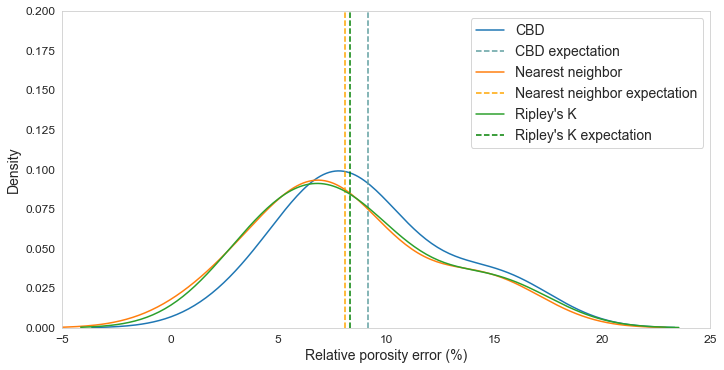

In [22]:
## Visuals
c = data.loc[:,'delta_error'].mean(axis = 0)
n = data.loc[:,'delta_errorNN'].mean(axis = 0)
k2 = data.loc[:,'delta_errorK2'].mean(axis = 0)


sns.kdeplot(data['delta_error'], label='CBD' )
plt.plot([c,c],[0.0,0.25],color = 'cadetblue',linestyle='--',label= 'CBD expectation')


sns.kdeplot(data['delta_errorNN'], label='Nearest neighbor' )
plt.plot([n,n],[0.0,0.25],color = 'orange',linestyle='--', label = 'Nearest neighbor expectation')


sns.kdeplot(data['delta_errorK2'], label="Ripley's K")
plt.plot([k2,k2],[0.0,0.25],color = 'green',linestyle='--', label = "Ripley's K expectation")


sns.set_style("white")
plt.legend(loc ="best",fontsize =14)
plt.xlabel('Relative porosity error (%)',fontsize =14)
plt.ylabel('Density',fontsize =14)
plt.ylim(0,0.20);plt.xlim(-5,25)
plt.tick_params(axis='both', labelsize=12)
plt.grid(False)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.1, wspace=0.2, hspace=0.2)
plt.savefig('errors.png', dpi=300, bbox_inches='tight')
plt.show()